In [203]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import cv2 as cv
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import random as rd

In [209]:
data_path = '../data/bird_data'
n_images = 21

name1 = "0007"
name2 = "0008"

In [210]:
img1 = plt.imread(os.path.join(data_path, "images", name1+'.ppm'))
img2 = plt.imread(os.path.join(data_path, "images", name2+'.ppm'))
h, w, _ = img1.shape

P1 = np.loadtxt(os.path.join(data_path, "calib", name1+'.txt'), skiprows=1)
P2 = np.loadtxt(os.path.join(data_path, "calib", name2+'.txt'), skiprows=1)

silhouette1 = plt.imread(os.path.join(data_path, "silhouettes", name1+'.pgm')) == 0
silhouette2 = plt.imread(os.path.join(data_path, "silhouettes", name2+'.pgm')) == 0

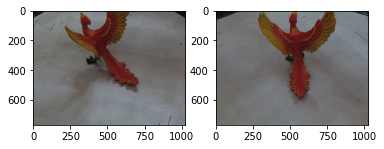

In [211]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(img1)
f.add_subplot(1,2,2)
plt.imshow(img2)
plt.show()

In [212]:
# x = (X, Y, w)
def x_to_img_coordinates(x):
    return int(x[0]/x[2]), int(x[1]/x[2])

In [213]:
# x = (X, Y, w)
def x_to_np_coordinates(x):
    i, j = x_to_img_coordinates(x)
    return j, i

In [216]:
# x = (X, Y, w)
def scatter(x):
    i, j = x_to_img_coordinates(x)
    plt.scatter([i], [j], c='r')

In [217]:
def epipolar_y(x, l):
    return (-l[2] - l[0]*x)/l[1]

In [218]:
def plot_epipolar_line(img, l, show=True):
    plt.imshow(img)
    i1,j1 = x_to_img_coordinates([0,  epipolar_y(0, l), 1])
    i2,j2 = x_to_img_coordinates([w-1,  epipolar_y(w-1, l), 1])
    plt.plot([i1,i2], [j1, j2], 'r')
    plt.xlim([0,w-1])
    plt.ylim([h-1,0])
    if show:
        plt.show()

In [219]:
def lie_matrix(v):
    M = np.zeros((3,3))
    M[0,1] = -v[2]
    M[0,2] =  v[1]
    M[1,0] =  v[2]
    M[1,2] = -v[0]
    M[2,0] = -v[1]
    M[2,1] =  v[0]
    return M

In [220]:
def compute_F(P1, P2):
    P1x_ = np.linalg.inv(P1[:,:3])
    return (lie_matrix(P2[:,-1]) - lie_matrix(P2[:,:3] @ P1x_ @ P1[:,-1])) @ P2[:,:3] @ P1x_

In [221]:
F = compute_F(P1, P2)

In [278]:
def distance(patch1, patch2):
    #return spatial.distance.cosine(patch1-patch1.mean(), patch2-patch2.mean())
    return np.sum(((patch1-patch1.mean()) - (patch2-patch2.mean()))**2)

In [279]:
def find_x2(x1, F, img1, img2, kernel_size=[5,5], show=False):
    padding_i, padding_j = kernel_size[0]//2, kernel_size[1]//2
    
    i, j = x_to_np_coordinates(x1)
    if i <= padding_i or i >= h - padding_i or j <= padding_j or j >= w - padding_j:
        return None

    patch1 = img1[(i-padding_i):(i+padding_i+1), (j-padding_j):(j+padding_j+1)].flatten()
    
    shortest_distance = np.inf
    best_x2 = None
    l = F @ x1
    distances = []
    for x in range(padding_j, w-padding_j):
        y = epipolar_y(x, l)
        i, j = x_to_np_coordinates([x, y, 1])
        if i > padding_i and i < h - padding_i:
            patch2 = img2[(i-padding_i):(i+padding_i+1), (j-padding_j):(j+padding_j+1)].flatten()
            d = distance(patch1, patch2)
            distances.append(d)
            if d < shortest_distance:
                shortest_distance = d
                best_x2 = [x, y, 1]
    if show:
        plt.plot(distances)
        plt.show()
        
    return best_x2

In [280]:
x = np.array([690, 480, 1])

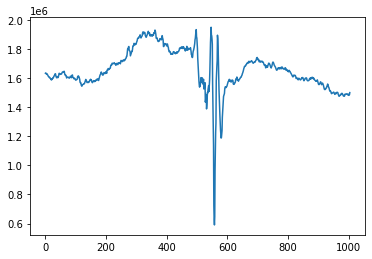

In [281]:
x2 = find_x2(x, F, img1, img2, kernel_size=[20,20], show=True)

In [268]:
def show_best_x2(img1, img2, x1, x2, l):
    f = plt.figure()
    f.add_subplot(1,2,1)
    plt.imshow(img1)
    scatter(x1)
    f.add_subplot(1,2,2)
    plot_epipolar_line(img2, l, show=False)
    scatter(x2)
    plt.show()

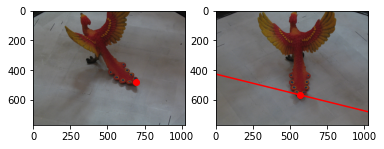

In [269]:
show_best_x2(img1, img2, x, x2, F @ x)

In [270]:
from scipy.optimize import minimize, LinearConstraint

def get_X(x, x2):
    A = np.array([
        x[0]*P1[2,:] - P1[0,:],
        x[1]*P1[2,:] - P1[1,:],
        x2[0]*P2[2,:] - P2[0,:],
        x2[1]*P2[2,:] - P2[1,:]
    ])
    
    def fun(x):
        x[-1] = 1
        return np.sum((A @ x)**2)
    
    x0 = [0,0,0,1]
    res = minimize(fun, x0)
    return res.x

X = get_X(x,x2)

In [271]:
def get_SIFT_keypoints(img, silhouette, show=False):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    
    kp = sift.detect(gray, None)
    x_list = list(map(lambda x: list(map(int, x.pt))+[1], kp))
    
    x_list, kp = zip(*[(x, k) for x, k in zip(x_list, kp) if is_inside(x, silhouette)])
   
    if show:
        img_kp = cv.drawKeypoints(gray, kp, img.copy())
        plt.imshow(img_kp)

    return x_list

In [272]:
def is_inside(x, silhouette):
    return silhouette[x_to_np_coordinates(x)]

189 points of interest


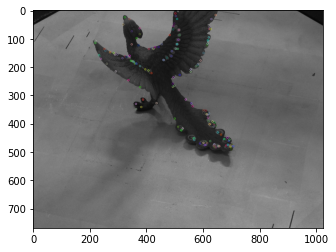

In [273]:
x_list = get_SIFT_keypoints(img1, silhouette1, show=True)
print(f"{len(x_list)} points of interest")

In [274]:
x1_x2_list = []
for x1 in tqdm(x_list):
    x2 = find_x2(x1, F, img1, img2, kernel_size=[20,20])
    if x2 is not None:
        x1_x2_list.append((x1, x2))

100%|██████████| 189/189 [00:11<00:00, 15.77it/s]


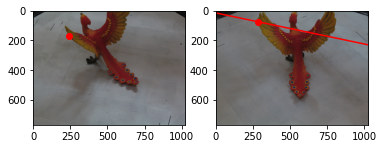

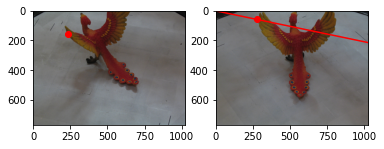

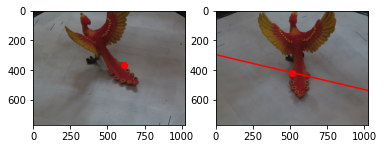

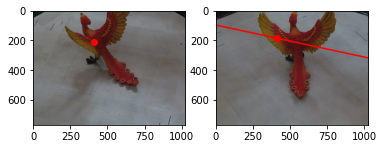

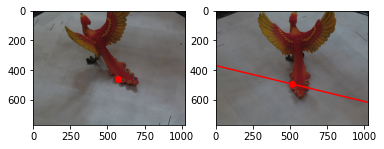

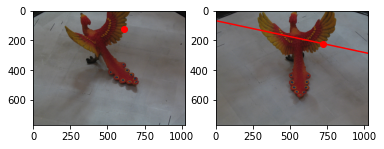

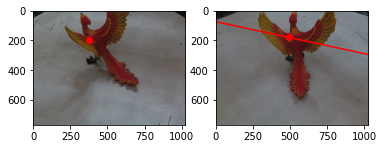

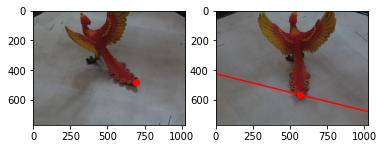

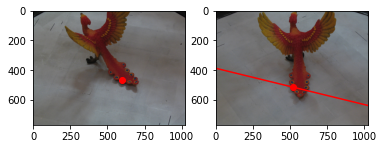

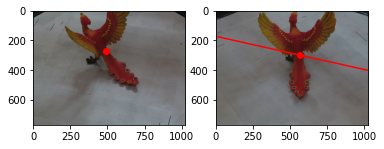

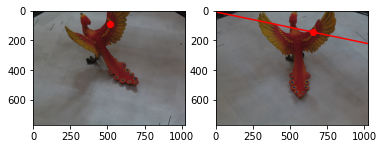

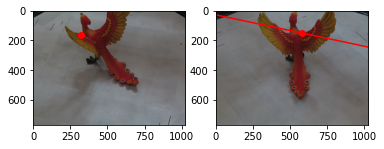

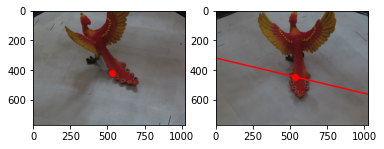

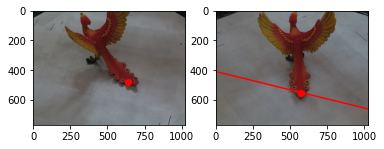

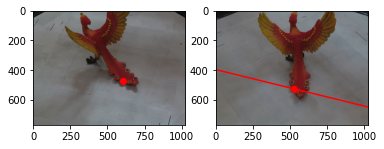

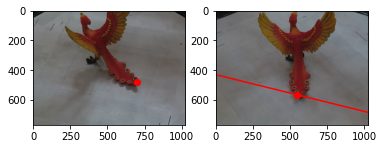

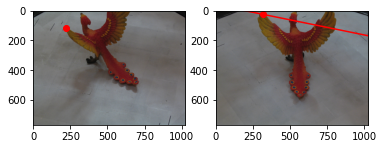

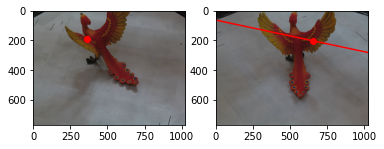

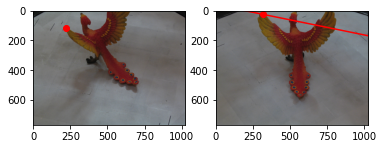

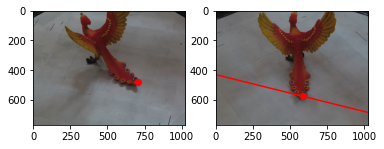

In [275]:
for x1, x2 in sorted(x1_x2_list, key=lambda k: rd.random())[:20]:
    show_best_x2(img1, img2, x1, x2, F @ x1)

In [276]:
X_list = [get_X(*x1_x2) for x1_x2 in tqdm(x1_x2_list)]

100%|██████████| 189/189 [00:00<00:00, 405.22it/s]


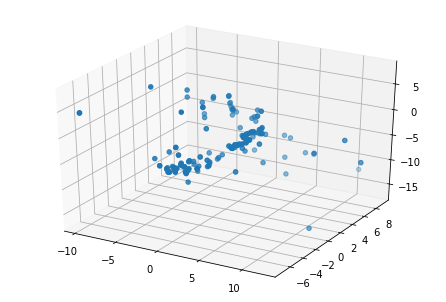

In [277]:
%matplotlib inline 
#%matplotlib notebook 
fig = plt.figure()
ax = Axes3D(fig)

X_list = np.array(X_list)
ax.scatter(X_list[:,0], X_list[:,1], X_list[:,2])